In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_x2_var, get_x2_var_short_time
from functions import get_var_hist,simulate_traj, create_R, get_prop_abs, get_steady_mean, get_theo_var_l, get_non_delayed_prop, get_non_delayed_dyn
from setup import setup_matplotlib, one_col, std_height, two_col
from timeit import default_timer as timer

setup_matplotlib()

np.random.seed(42)

In [3]:
k = 1
s = 1
D = s**2/2
max_t = 6
ntau = 3
# dx = 0.3
N_x = 21
eq_perc = 0.75


f = 30
N_p = 2_000
N_loop = 10



def force(x,*args):
     return -k*x

ltaus = np.concatenate(([0,0.05], np.arange(0.2,2.2,0.1) ))
sbs = np.empty(len(ltaus))
sim_vars = np.empty((len(ltaus),2))
sim_eq_time = np.empty((len(ltaus),2))

sim_hist_vars = np.empty((len(ltaus),2))
sim_hist_eq_time = np.empty((len(ltaus),2))

num_vars = np.empty((len(ltaus),2))
num_eq_time = np.empty((len(ltaus),2))

sim_times = np.empty(len(ltaus))
num_times = np.empty(len(ltaus))

In [4]:
for i,ltau in enumerate(tqdm(ltaus)): 
    start = timer()
    ldt = ltau/ntau if ltau > 0 else 0.01
    N_t = max(int(max_t/ldt), 30)
    sim_ts = np.arange(0,f*(N_t+ntau))*ldt/f-ltau
    
    
    pos = simulate_traj(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau)*f, ntau=ntau*f, s=s, dt=ldt/f,border=0, force=force)
    sim_var = np.var(pos, axis = 1)
    
    # adapt boundaries to varianz (from sim) -> 3 sigma
    sbs[i] = 3*np.sqrt(np.max(sim_var))
    sb = sbs[i]
    #sb = min(20*dx, np.round(sb/dx)*dx)
    dx = 2*sb/(N_x-1)
    
    x_s = np.arange(-sb,sb+1e-6,dx)
    bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
    
    sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
    sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)
    
    mean_sim_vars = np.mean(sim_var[:,-f*ntau*2:], axis = 1)
    sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))
    
    mean_s_eq = sim_ts[np.argmin((eq_perc*mean_sim_vars[:,None]-sim_var)**2, axis = 1)]
    sim_eq_time[i] = (np.mean(mean_s_eq), np.std(mean_s_eq)/np.sqrt(N_loop))
    
    mean_sim_hist_var = np.mean(sim_hist_var[:,-f*ntau*2:], axis = 1)
    sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))
    
    mean_sh_eq = sim_ts[np.argmin((eq_perc*mean_sim_hist_var[:,None]-sim_hist_var)**2, axis = 1)]
    sim_hist_eq_time[i] = (np.mean(mean_sh_eq), np.std(mean_sh_eq)/np.sqrt(N_loop))
    end = timer()
    sim_times[i] = end-start
print(np.sum(sim_times))

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/18000 [00:00<?, ?it/s]

  0%|          | 0/10800 [00:00<?, ?it/s]

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/1770 [00:00<?, ?it/s]

  0%|          | 0/1320 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

170.415199348


In [5]:
for i,ltau in enumerate(tqdm(ltaus)):
    start = timer()
    ldt = ltau/ntau if ltau > 0 else 0.01
    N_t = max(int(max_t/ldt), 30)
    
    ts = np.arange(0,N_t)*ldt

    sb = sbs[i]
    dx = 2*sb/(N_x-1)

    x_s = np.arange(-sb,sb+1e-6,dx)
    i_zero = np.argmin(x_s**2)

    if ltau > 0:
        # v1
        # prop = get_prop_abs(x_s, force,D,ldt,dx)
        # R, _, end_states = create_R(N_x, ntau, prop)

        # v2
        prop = get_prop_abs_v2(x_s, force,D,ldt,dx)
        R, _, end_states = create_R_v1(N_x, ntau, prop)

        _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    else:
        R = get_non_delayed_prop(x_s, force,D,ldt,dx)
        hists = get_non_delayed_dyn(R,i_zero,N_t, N_x)
    
    num_var = get_var_hist(hists, x_s)

    mean_num_var = np.mean(num_var[-ntau*2:])
    num_vars[i] =  (mean_num_var, np.max(num_var[-ntau*2:])-np.min(num_var[-ntau*2:]))
    num_eq_time[i] =  ts[np.argmin((eq_perc*mean_num_var-num_var)**2)]
    end = timer()
    num_times[i] = end - start
print(np.sum(num_times))

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/29 [00:00<?, ?it/s]

8.599811944001885


In [7]:
short_time_approx_var = get_x2_var_short_time(ltaus, k, s)
exact_sol = get_x2_var(ltaus, k, s)

test_ts = np.linspace(0,max_t, 4000)
test_ltaus = np.arange(0,1.5,0.025)
exact_eqtimes = [test_ts[np.argmin((get_theo_var_l(test_ts,ltau,D) - eq_perc*get_x2_var(ltau, k, s))**2)] for ltau in test_ltaus]

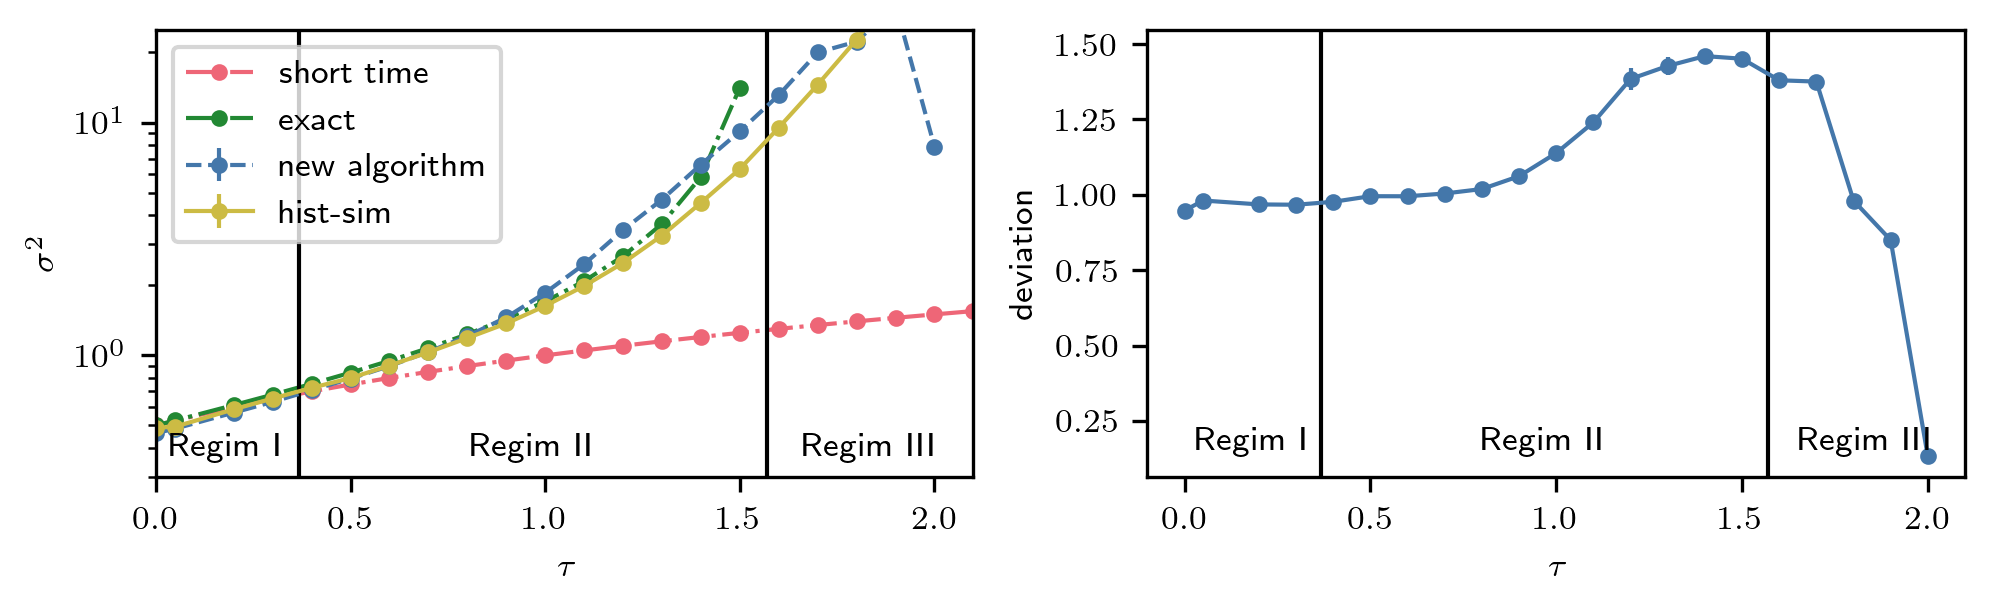

In [21]:
plt.figure(figsize=(two_col,std_height))
ax = plt.subplot(121)
#plt.plot(ltaus,sim_vars[:,0],'.-', label='sim')

plt.errorbar(ltaus,num_vars[:,0],num_vars[:,1],marker='.', ls='--', label='new algorithm')



plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')
plt.plot(ltaus[ltaus < np.pi/2/k],exact_sol[ltaus < np.pi/2/k] ,'.-.',label='exact')

plt.errorbar(ltaus,sim_hist_vars[:,0],sim_hist_vars[:,1],marker='.', label='hist-sim')
plt.ylim(3e-1,25)
plt.xlim(0,2.1)
plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
y = 4e-1
plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')

#auflösungslimit
#plt.hlines((x_s[-1]/3)**2, *plt.xlim())

ax = plt.subplot(122)
plt.errorbar(ltaus, num_vars[:,0]/sim_hist_vars[:,0], 
             yerr = np.sqrt( ( num_vars[:,1]/sim_hist_vars[:,0])**2 + (num_vars[:,0]/sim_hist_vars[:,0]**2*sim_hist_vars[:,1])**2),
                            marker = '.')
plt.ylim(*plt.ylim())
plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
y = 0.18
plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')
#plt.plot(ltaus, num_vars[:,0]/sim_vars[:,0], '.-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')


plt.tight_layout()
plt.savefig(f'graphics/x2variance_v2_Nx{N_x}_ntau{ntau}.pdf')

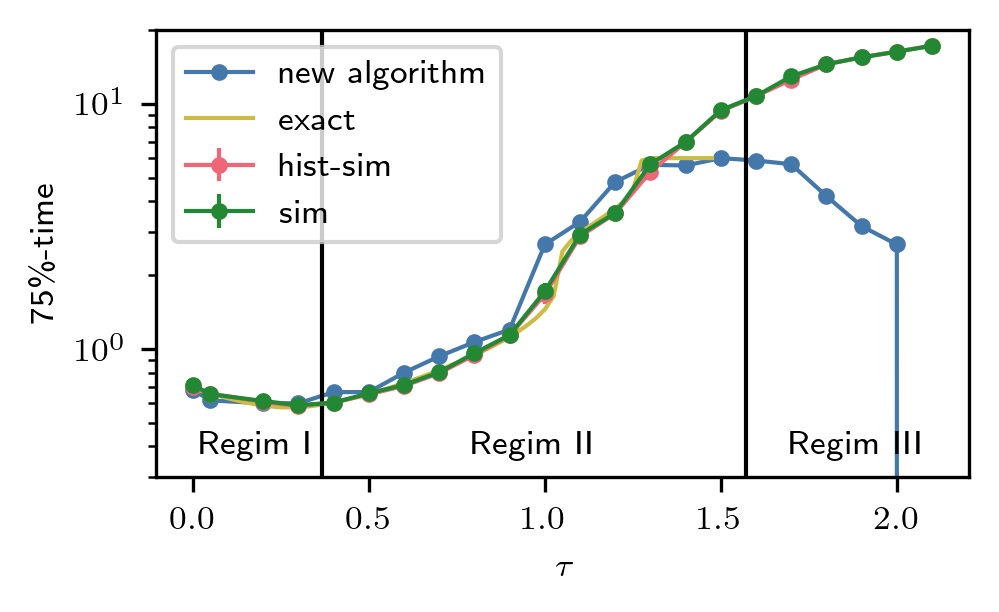

In [19]:
plt.plot(ltaus, num_eq_time[:,0], marker ='.', label = 'new algorithm')
plt.errorbar(ltaus, *sim_hist_eq_time.T, marker ='.', label = 'hist-sim')
plt.errorbar(ltaus, *sim_eq_time.T, marker ='.', label = 'sim')

plt.plot(test_ltaus, exact_eqtimes, label='exact')


plt.ylim(3e-1,2e1)
plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')

y = 4e-1
plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

plt.legend()
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'75\%-time')
plt.tight_layout()
plt.savefig(f'graphics/x2eqtime_v2_Nx{N_x}_ntau{ntau}.pdf')

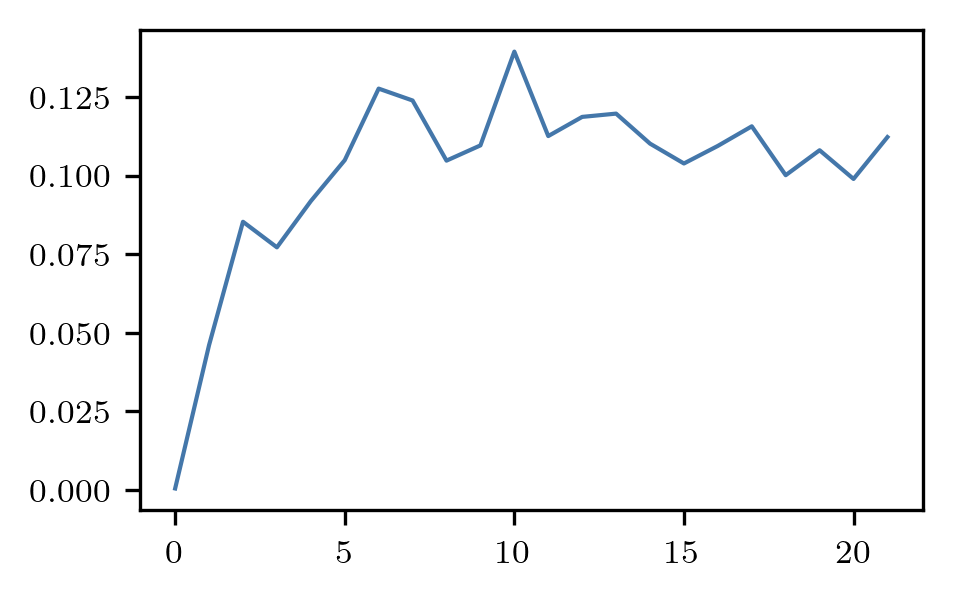

In [10]:
plt.plot(np.array(num_times)/np.array(sim_times))

In [11]:
x_s

array([-3.84886838e+01, -3.46398154e+01, -3.07909470e+01, -2.69420786e+01,
       -2.30932103e+01, -1.92443419e+01, -1.53954735e+01, -1.15466051e+01,
       -7.69773675e+00, -3.84886838e+00, -1.42108547e-14,  3.84886838e+00,
        7.69773675e+00,  1.15466051e+01,  1.53954735e+01,  1.92443419e+01,
        2.30932103e+01,  2.69420786e+01,  3.07909470e+01,  3.46398154e+01,
        3.84886838e+01])